In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import paper_classes_2 as pc
import Post_processing as pp
import itertools
import os
import import_ipynb
import comm_as_today_run as comm

importing Jupyter notebook from comm_as_today_run.ipynb


SyntaxError: unexpected EOF while parsing (<string>, line 15)

# First let's load the Swiss community with 100 houses from the CREM dataset

if it is the first time you run this script set first_time to True (to select randomly the demand profiles and the PV sizes), otherwise set it to False

In [2]:

def sell_prob(SOC,price,Capacity,flag_sp,path):
    '''
    Description
    -----------
    This function returns the selling probability based on the SOC, price, capacity and case. As well as the results of the survey which are stored as .txt
    Parameters
    ------
    SOC: float; Battery state of charge at time t
    price: float; Electricity price at time t
    Capacity: float; Battery capacity
    case: string; either PV or batt from where the user is willing to sale
    path: string; path where the .txt are found
    ------
    out: int; Either 1 or 0 if sell or not
    TODO
    ------
    '''
    #define the matrix of probs
    if flag_sp==2:
        prob_mat=pd.read_table(path+'Input/P_selling_by_price_and_autarky2.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/surplus_cluster1_p_selling.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/surplus_cluster2_p_selling.txt',sep='\t',index_col=[0])
    elif flag_sp==1:#when selling from battery day
        prob_mat=pd.read_table(path+'Input/P_selling_by_price_and_autarky_2.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/nosurplus_cluster1_p_selling.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/nosurplus_cluster2_p_selling.txt',sep='\t',index_col=[0])
    elif flag_sp==3:#when selling from battery night
        prob_mat=pd.read_table(path+'Input/P_selling_by_price_and_autarky_2.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/nosurplus_cluster1_p_selling.txt',sep='\t',index_col=[0])
        #prob_mat=pd.read_table(path+'Input/nosurplus_cluster2_p_selling.txt',sep='\t',index_col=[0])
    
    if SOC==0:
        out=0
    else:
        I=np.array([0,0.05,0.2,0.35,0.5,0.65,0.8,0.95,1.0001])#define the interval of SOC
        ind=find_interval(SOC,I*Capacity)
        if ind==-1:
            prob=prob_mat.loc[1,str(price)]
        else:
            prob=prob_mat.loc[I[ind],str(price)]
        out=np.random.choice(2,1,p=[1-prob,prob]) 
    return out

In [3]:

def find_interval_PQ(x, partition):
    '''
    Description
    -----------
    find_interval at which x belongs inside partition. Returns the index i.

    Parameters
    ------
    x: float; numerical value
    partition: array; sequence of numerical values
    Returns
    ------
    i: index; index for which applies
    partition[i] < x < partition[i+1], if such an index exists.
    -1 otherwise
    TODO
    ------
    '''
    
    for i in range(0, len(partition)):
        #print(partition)
        if x<partition[1]:
            return 1
        elif x < partition[i]:
            return i-1
        
    return -1

In [4]:

def find_interval(x, partition):
    '''
    Description
    -----------
    find_interval at which x belongs inside partition. Returns the index i.

    Parameters
    ------
    x: float; numerical value
    partition: array; sequence of numerical values
    Returns
    ------
    i: index; index for which applies
    partition[i] < x < partition[i+1], if such an index exists.
    -1 otherwise
    TODO
    ------
    '''

    for i in range(0, len(partition)):
        if x < partition[i]:
            return i-1
    return -1



In [5]:
def get_surplus_hour(res_pv):
#Get the first surplus hour
    sp_hour=[]
    if int(res_pv.shape[0]/365)==24:
        aux_res_pv=np.array(res_pv).reshape((365,24))
    else:
        print('TODO')
        
        
    for day in range(0,365):
        sp_hour.append(np.argmax(aux_res_pv.reshape((365,24))[day]>0))
    return sp_hour

In [67]:

def dispatch_probs(pv, demand, param, return_series=False):
    """ Self consumption maximization pv + battery dispatch algorithm.
    The dispatch of the storage capacity is performed in such a way to maximize self-consumption:
    the battery is charged when the PV power is higher than the load and as long as it is not fully charged.
    It is discharged as soon as the PV power is lower than the load and as long as it is not fully discharged.
    Arguments:
        pv (pd.Series): Vector of PV generation, in kW DC (i.e. before the inverter)
        demand (pd.Series): Vector of household consumption, kW
        param (dict): Dictionary with the simulation parameters:
                timestep (float): Simulation time step (in hours)
                BatteryCapacity: Available battery capacity (i.e. only the the available DOD), kWh
                BatteryEfficiency: Battery round-trip efficiency, -
                InverterEfficiency: Inverter efficiency, -
                MaxPower: Maximum battery charging or discharging powers (assumed to be equal), kW
        return_series(bool): if True then the return will be a dictionary of series. Otherwise it will be a dictionary of ndarrays.
                        It is reccommended to return ndarrays if speed is an issue (e.g. for batch runs).
    Returns:
        dict: Dictionary of Time series
    """
    path=os.getcwd()+'/Switzerland/'
    kW_dis= param['kW_dis']
    bat_size_e_adj = param['BatteryCapacity']
    bat_size_p_adj = param['MaxPower']
    n_bat = param['BatteryEfficiency']
    n_inv = param['InverterEfficiency']
    timestep = param['timestep']
    # We work with np.ndarrays as they are much faster than pd.Series
    Nsteps = len(pv)
    LevelOfCharge = np.zeros(Nsteps)
    pv2store = np.zeros(Nsteps)
    inv2grid = np.zeros(Nsteps)
    store2inv = np.zeros(Nsteps)
    store2load = np.zeros(Nsteps)
    grid2store = np.zeros(Nsteps) # TODO Always zero for now.
    store2grid = np.zeros(Nsteps)
    batt_losses = np.zeros(Nsteps)
    prices = np.array(param['df_prices']).flatten()
    #prices=np.ones(Nsteps)*.07
    #Load served by PV
    pv2inv = np.minimum(pv, demand / n_inv)  # DC direct self-consumption

    #Residual load
    res_load = (demand - pv2inv * n_inv)  # AC
    inv2load = pv2inv * n_inv  # AC

    #Excess PV
    res_pv = np.maximum(pv - demand/n_inv, 0)  # DC
    #PV to storage after eff losses
    pv2inv = pv2inv.values

    #first timestep = 0
    LevelOfCharge[0] = 0  # bat_size_e_adj / 2  # DC
    ######################################
    sp_hour=get_surplus_hour(res_pv)
    
    for i in range(1,Nsteps):
        ######################################
        if sp_hour[int(np.floor((i)/24))]==0:#no surplus at all
            flag_sp=3
        elif i%24<sp_hour[int(np.floor((i)/24))]-2:#2h bf surplus
            flag_sp=1
        elif i%24>sp_hour[int(np.floor((i)/24))]-14+24: #14h bf surplus
            flag_sp=3
        else:#while sp
            flag_sp=2
        ######################################
        #PV to storage
        if (sell_prob(LevelOfCharge[i-1],prices[i],bat_size_e_adj,flag_sp,path)&(flag_sp==2)):
            aux=res_pv[i]-min(kW_dis/n_inv/timestep,res_pv[i])
            pv2inv[i]=pv2inv[i]+aux
            res_pv[i]=res_pv[i]-aux
            inv2grid[i]=aux#DC
            
            

        if LevelOfCharge[i-1] >= bat_size_e_adj:  # if battery is full
                pv2store[i] = 0
        else: #if battery is not full
            if LevelOfCharge[i-1] + res_pv[i] * timestep > bat_size_e_adj:  # if battery will be full after putting excess
                pv2store[i] = min((bat_size_e_adj - LevelOfCharge[i-1]) / timestep, bat_size_p_adj)
            else:
                pv2store[i] = min(res_pv[i], bat_size_p_adj)

        #Storage to load or grid
        ######################################
        batt_losses[i]=pv2store[i]*(1-n_bat)
        if pv2store[i]==0:#not charging
            store2load[i] = min(bat_size_p_adj,  # DC
                           res_load[i] / n_inv,
                           LevelOfCharge[i-1] / timestep)
            if (sell_prob(LevelOfCharge[i-1]-store2load[i],prices[i],bat_size_e_adj,flag_sp,path)&(flag_sp!=2)):
                store2grid[i] = min(bat_size_p_adj-store2load[i]/timestep,  # DC
                                   kW_dis / n_inv/timestep/n_bat,
                                   (LevelOfCharge[i-1]-store2load[i]) / timestep)
                store2inv[i] = (store2load[i]+store2grid[i])
            else:
                store2inv[i]=store2load[i]
        ######################################a
        
        #SOC
        LevelOfCharge[i] = min(LevelOfCharge[i-1] - batt_losses[i]-(store2inv[i] - pv2store[i] - grid2store[i]) * timestep,  # DC
                               bat_size_e_adj)

    store2grid=store2grid # AC
    pv2inv = pv2inv + res_pv - pv2store
    inv2load = inv2load + store2load * n_inv  # AC
    inv2grid = (inv2grid+res_pv - pv2store+store2grid) * n_inv  # AC
    grid2load = demand - inv2load  # AC
    #MaxDischarge = np.minimum(LevelOfCharge[i-1]*BatteryEfficiency/timestep,MaxPower)


    #Potential Grid to storage  # TODO: not an option for now in this strategy
    # GridPurchase = False

    out = {'pv2inv': pv2inv,
            'res_pv': res_pv,
            'pv2store': pv2store,
            'inv2load': inv2load,
            'grid2load': grid2load,
            'store2inv': store2inv,
            'LevelOfCharge': LevelOfCharge,
            'inv2grid': inv2grid,
            'store2grid':store2grid,
            'store2load':store2load
            # 'grid2store': grid2store
            }
    if not return_series:
        out_pd = {}
        for k, v in out.items():  # Create dictionary of pandas series with same index as the input pv
            out_pd[k] = pd.Series(v, index=pv.index)
        out = out_pd
    return out

In [7]:

def price_probability(df_CH,selection,inputs):
    '''
    Description
    -----------
    Define the price structure according to the inputs (how the community is created), the choice of the probability, 
    whether it is for the 50% or other probability according to the psychology data, the amount of kWh that will be 
    discharged every time a decision is made (1 or 2 kWh are the "normal" options) and the case, whether it is the
    price created from the probability of selling from PV or the battery in the morning or the evening.
    
    Parameters
    ------
    inputs:        dict; Dictionary that includes prob_choice (choice of the probability to create the prices 50% or other),
                    prices, kWh_dis (amount of energy to be discharged at every time a decision is made),  
                    case (included in ['PV', 'Batt'] the price may be created from the probability of selling from PV or the battery

    Return
    ------
    inputs: dict; Input dictionary updated with prices

    TODO
    ------

    '''
    list_names=[str(name) for name in selection.name]
    # Get the total demand
    sum_demand=df_CH.loc[:,list_names].sum(axis=1)
    # Get total PV generation
    aux=pd.DataFrame()
    sum_PV=pd.DataFrame()
    for i in range(len(selection)):
        aux=df_CH.E_PV*selection.PV_size[i]
        if i==0:
            sum_PV=aux
        else:
            sum_PV=aux+sum_PV

    net_demand=sum_demand-sum_PV
    prob_mat_PV=pd.read_csv('Switzerland/Input/P_selling_by_price_and_autarky2.txt',sep='\t',index_col=[0])
    prob_mat_Batt=pd.read_csv('Switzerland/Input/P_selling_by_price_and_autarky_2.txt',sep='\t',index_col=[0])
    sp_hour=get_surplus_hour(sum_PV-sum_demand)
    if len(inputs['prob_choice'])==1:
        q_supply_midday=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['community_size']))*prob_mat_PV.loc[inputs['prob_choice'][0],:]*inputs['kW_dis']
        q_supply_other=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['community_size']))*prob_mat_Batt.loc[inputs['prob_choice'][0],:]*inputs['kW_dis']
        df_prices=pd.DataFrame(index=net_demand.index)
        df_prices.loc[:,'prices']=net_demand.apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_midday)])
        df_prices.loc[(df_prices.index.hour<sp_hour[int(np.floor((i)/24))]-2)|(df_prices.index.hour>sp_hour[int(np.floor((i)/24))]-14+24),'prices']=net_demand[(net_demand.index.hour<sp_hour[int(np.floor((i)/24))]-2)|(net_demand.index.hour>sp_hour[int(np.floor((i)/24))]-14+24)].apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_other)])
        inputs.update({'df_prices':df_prices})
        return inputs
    elif len(inputs['prob_choice'])==3:
        q_supply_morning=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['community_size']))*prob_mat_Batt.loc[inputs['prob_choice'][0],:]*inputs['kW_dis']
        q_supply_midday=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['community_size']))*prob_mat_PV.loc[inputs['prob_choice'][1],:]*inputs['kW_dis']
        q_supply_evening=int(np.floor(inputs['PV_penetration']*inputs['Batt_penetration']*inputs['community_size']))*prob_mat_Batt.loc[inputs['prob_choice'][2],:]*inputs['kW_dis']
        df_prices=pd.DataFrame(index=net_demand.index)
        df_prices.loc[:,'prices']=net_demand.apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_midday)])
        df_prices.loc[(df_prices.index.hour<sp_hour[int(np.floor((i)/24))]-2),'prices']=net_demand[net_demand.index.hour<sp_hour[int(np.floor((i)/24))]-2].apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_morning)])
        df_prices.loc[df_prices.index.hour>sp_hour[int(np.floor((i)/24))]-14+24,'prices']=net_demand[net_demand.index.hour>sp_hour[int(np.floor((i)/24))]-14+24].apply(lambda x:inputs['prices'][find_interval_PQ(x,q_supply_evening)])

        inputs.update({'df_prices':df_prices})
        return inputs
    else:
        print('Warning: this function only takes either one choice of probability for the whole day or three separated for morning, midday and evening')
        return

In [43]:
first_time=True
community_size=100
timestep=1 # in hours
if first_time:
    out_comm_final=comm.load_obj('community_as_today')
param_tech=out_comm_final['param_tech']
param_tech.update({'kW_dis':1})

df_CH=out_comm_final['df']
selection=out_comm_final['selection']
pv_penetration=50
batt_penetration=50
param_tech.update({'kW_dis':1,'PV_penetration':pv_penetration/100,'Batt_penetration':batt_penetration/100,'prob_choice':[0.35,0.5,.95],
            'prices':np.array([0, 0.07,.10,.13,.16,.19,.22,.25,.28]),'community_size':community_size})

In [44]:
price_probability(df_CH,selection,param_tech)
print()

In [45]:
out1=dispatch_probs(df_CH.E_PV*selection.PV_size[1],df_CH.loc[:,str(selection.name[1])],param_tech)

In [46]:
out2=comm.dispatch_max_sc(df_CH.E_PV*selection.PV_size[1],df_CH.loc[:,str(selection.name[1])],param_tech)

In [47]:
comm.print_analysis(df_CH.E_PV*selection.PV_size[1],df_CH.loc[:,str(selection.name[1])],param_tech,out1)#probs

Total yearly consumption: 1756.6 kWh
Total PV production: 4201.17 kWh
Self Consumption: 1522.16 kWh
Total fed to the grid: 2424.85 kWh
Total bought from the grid: 234.435 kWh
Self consumption rate (SCR): 36.2%
Self sufficiency rate (SSR): 86.7%
Amount of energy provided by the battery: 2607.3 kWh
Average Charging/Discharging depth: 0.714329
Number of equivalent full cycles per year: 260.73 
Total battery losses: 2.22124 kWh
Total inverter losses: 251.937 kWh
Total injected to grid from battery: 1771.14 kWh
Residue (check): 4.54747e-13 kWh


In [48]:
comm.print_analysis(df_CH.E_PV*selection.PV_size[1],df_CH.loc[:,str(selection.name[1])],param_tech,out1)#no probs

Total yearly consumption: 1756.6 kWh
Total PV production: 4201.17 kWh
Self Consumption: 1522.16 kWh
Total fed to the grid: 2424.85 kWh
Total bought from the grid: 234.435 kWh
Self consumption rate (SCR): 36.2%
Self sufficiency rate (SSR): 86.7%
Amount of energy provided by the battery: 2607.3 kWh
Average Charging/Discharging depth: 0.714329
Number of equivalent full cycles per year: 260.73 
Total battery losses: 2.22124 kWh
Total inverter losses: 251.937 kWh
Total injected to grid from battery: 1771.14 kWh
Residue (check): 4.54747e-13 kWh


In [49]:
# Energy balance
df1=pd.DataFrame(out1)
df1.columns
(df_CH.E_PV*selection.PV_size[1]).sum()#PV

(df1.pv2inv+df1.pv2store).sum()#PV

(df1.pv2inv+df1.store2inv).sum()#DC inv

(df1.inv2grid+df1.inv2load).sum()# AC inv

(df1.pv2inv+df1.store2inv).sum()*(1-.94)#inv losses

(df1.pv2store-df1.store2grid-df1.store2load).sum()#batt losses

(df1.inv2grid-df1.store2grid*.94).sum()#pv2grid AC

(df1.inv2load-df1.store2load*.94).sum()#pv2load AC

(df1.pv2inv*.94-(df1.inv2load-df1.store2load*.94)-(df1.inv2grid-df1.store2grid*.94)).sum()

(df1.pv2store*(.00091)).sum()

(df1.inv2grid-df1.store2grid).sum()

(df1.store2inv-(df1.store2grid+df1.store2load)).sum()

0.0

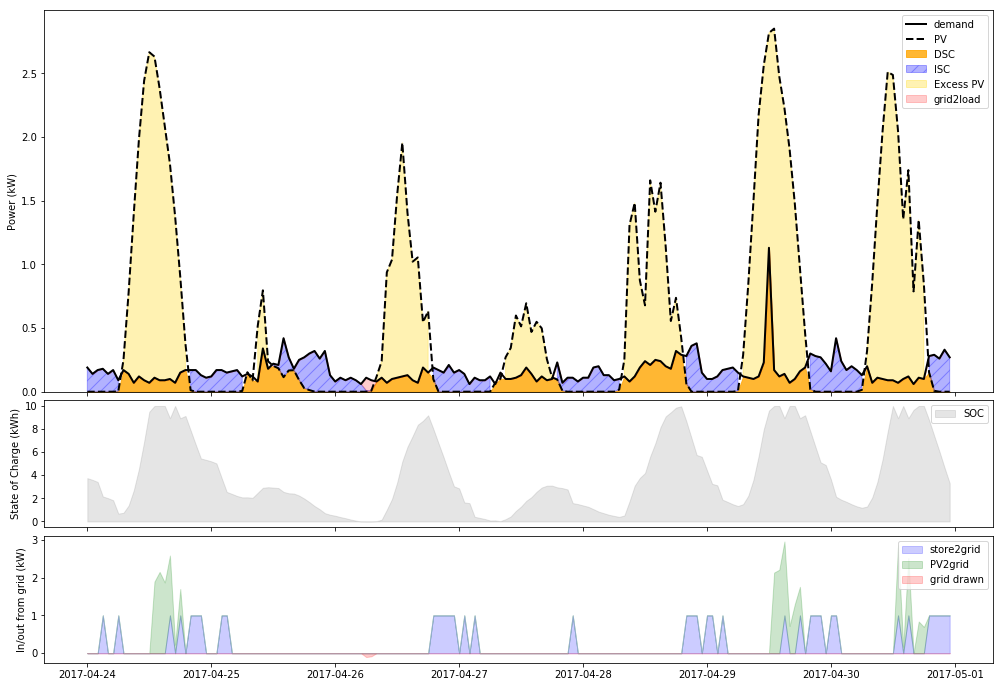

In [50]:
comm.plot_dispatch(df_CH.E_PV*selection.PV_size[1],df_CH.loc[:,str(selection.name[1])],out1,param_tech,week=17)

In [58]:
%%time
param_tech_no_batt=param_tech.copy()
param_tech_no_batt.update({'BatteryCapacity':0,'MaxPower':0})

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 21.9 µs


In [68]:
%%time
nested_out={}
j=0
k=0
PV_size_comm=0
for i in selection.index:
    print(i, end='')
    if selection.loc[i,'sub_'+str(out_comm_final['pv_penetration'])+'_100']:#all with PV
        PV_size_comm+=selection.PV_size[i]
        if selection.loc[i,'sub_'+str(out_comm_final['pv_penetration'])+'_'+str(out_comm_final['batt_penetration'])]: #if battery
            nested_out[i]=dispatch_probs(df_CH.E_PV*selection.PV_size[i],df_CH.loc[:,str(selection.name[i])],param_tech)
            j+=1
        else: #if only PV battery=0 kWh
            nested_out[i]=dispatch_probs(df_CH.E_PV*selection.PV_size[i],df_CH.loc[:,str(selection.name[i])],param_tech_no_batt)
            k+=1
    else: #No PV
        nested_out[i]=dispatch_probs(df_CH.E_PV*0,df_CH.loc[:,str(selection.name[i])],param_tech_no_batt)
    

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899CPU times: user 48min 20s, sys: 1min 6s, total: 49min 27s
Wall time: 49min 28s


In [69]:
#get all the data in a single dict
pv2inv=pd.DataFrame()
res_pv=pd.DataFrame()
pv2store=pd.DataFrame()
inv2load=pd.DataFrame()
grid2load=pd.DataFrame()
store2inv=pd.DataFrame()
LevelOfCharge=pd.DataFrame()
inv2grid=pd.DataFrame()
for i in nested_out.keys():
    pv2inv['pv2inv'+str(i)]=nested_out[i]['pv2inv']
    pv2store['pv2store'+str(i)]=nested_out[i]['pv2store']
    inv2load['inv2load'+str(i)]=nested_out[i]['inv2load']
    store2inv['store2inv'+str(i)]=nested_out[i]['store2inv']
    LevelOfCharge['LevelOfCharge'+str(i)]=nested_out[i]['LevelOfCharge']
    res_pv['res_pv'+str(i)]=nested_out[i]['res_pv']#not important, recalculated later
    inv2grid['inv2grid'+str(i)]=nested_out[i]['inv2grid']#not important, recalculated later
    grid2load['grid2load'+str(i)]=nested_out[i]['grid2load']#not important, recalculated later
nested_dict={'pv2inv':pv2inv.sum(axis=1),'res_pv':res_pv.sum(axis=1),'pv2store':pv2store.sum(axis=1),'inv2load':inv2load.sum(axis=1),
             'grid2load':grid2load.sum(axis=1),'store2inv':store2inv.sum(axis=1),'LevelOfCharge':LevelOfCharge.sum(axis=1),'inv2grid':inv2grid.sum(axis=1)}

Now calculate how the excess of PV will be absorbed in the remaining load of the community (all households without batteries)

In [70]:
out_comm_res=dispatch_probs(nested_dict['inv2grid'],nested_dict['grid2load'],param_tech_no_batt)

Finaly create the dictionary combining the results from the households with PV, PV and battery and without.

In [71]:
out_comm_final={}
out_comm_final['pv2inv']=nested_dict['pv2inv']
out_comm_final['pv2store']=nested_dict['pv2store']
out_comm_final['inv2load']=(nested_dict['inv2load']+out_comm_res['inv2load'])
out_comm_final['store2inv']=nested_dict['store2inv']
out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge']
out_comm_final['res_pv']=out_comm_res['res_pv']
out_comm_final['inv2grid']=out_comm_res['inv2grid']
out_comm_final['grid2load']=out_comm_res['grid2load']
out_comm_final['battery_losses']=nested_dict['pv2store']-nested_dict['store2inv']
out_comm_final['inverter_losses']=(nested_dict['pv2inv']+nested_dict['pv2store']-out_comm_final['battery_losses']+out_comm_res['pv2inv']+out_comm_res['pv2store'])*(1-param_tech['InverterEfficiency'])
out_comm_final['PV_size_comm']=PV_size_comm
out_comm_final['df']=df_CH
out_comm_final['param_tech']=param_tech
out_comm_final['nested_dict']=nested_dict
out_comm_final['pv_penetration']=pv_penetration
out_comm_final['batt_penetration']=batt_penetration
out_comm_final['selection']=selection


Run the analysis of the community with the PV size equals to the sum of all PV sizes and with the aggregated demand

In [83]:
list_names=[str(i) for i in selection.iloc[:,1]]

In [84]:
comm.print_analysis(df_CH.E_PV*PV_size_comm, df_CH.loc[:,list_names].sum(axis=1),param_tech_no_batt,out_comm_final)

Total yearly consumption: 285125 kWh
Total PV production: 372084 kWh
Self Consumption: 162777 kWh
Total fed to the grid: 165705 kWh
Total bought from the grid: 122347 kWh
Self consumption rate (SCR): 43.7%
Self sufficiency rate (SSR): 57.1%
Amount of energy provided by the battery: 60959.6 kWh
Average Charging/Discharging depth: inf
Number of equivalent full cycles per year: inf 
Total battery losses: 6052.48 kWh
Total inverter losses: 37549.3 kWh
Residue (check): 0 kWh


comm_as_today_run.ipynb:29: RuntimeWarning: divide by zero encountered in double_scalars
  "        E (dict):  Energy flows. Dictionary of pd.Series: res_pv, grid2load, store2inv, LevelOfCharge\n",


In [92]:
comm.print_analysis(df_CH.E_PV*PV_size_comm, df_CH.loc[:,list_names].sum(axis=1),param_tech_no_batt,out_comm_final)

Total yearly consumption: 285125 kWh
Total PV production: 372084 kWh
Self Consumption: 162777 kWh
Total fed to the grid: 165705 kWh
Total bought from the grid: 122347 kWh
Self consumption rate (SCR): 43.7%
Self sufficiency rate (SSR): 57.1%
Amount of energy provided by the battery: 60959.6 kWh
Average Charging/Discharging depth: inf
Number of equivalent full cycles per year: inf 
Total battery losses: 6052.48 kWh
Total inverter losses: 37549.3 kWh
Residue (check): 0 kWh


comm_as_today_run.ipynb:29: RuntimeWarning: divide by zero encountered in double_scalars
  "        E (dict):  Energy flows. Dictionary of pd.Series: res_pv, grid2load, store2inv, LevelOfCharge\n",


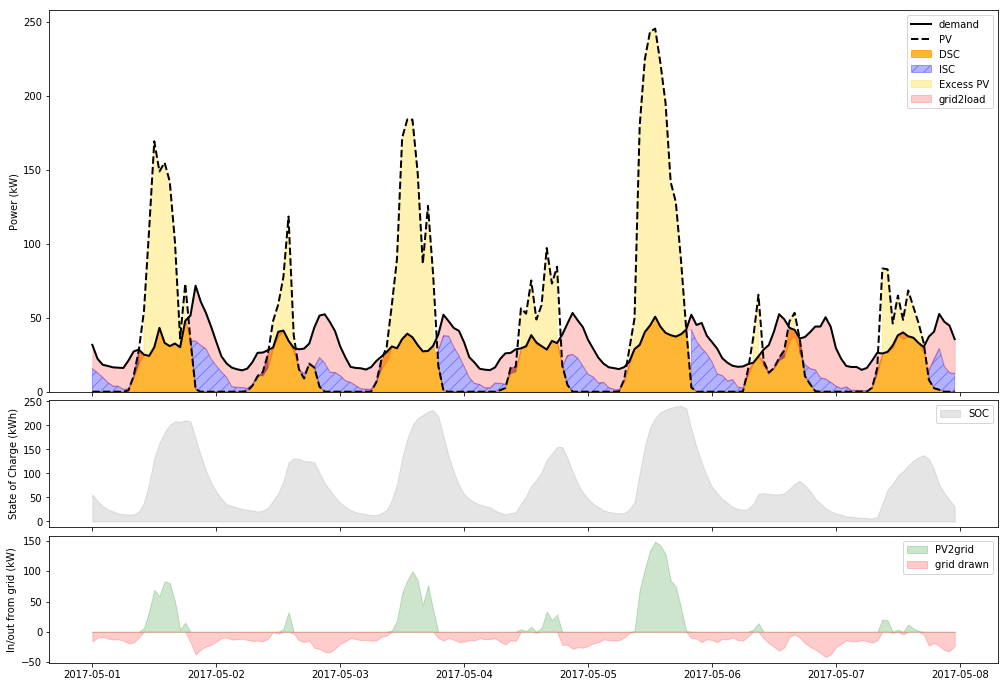

In [91]:
comm.plot_dispatch(df_CH.E_PV*PV_size_comm, df_CH.loc[:,list_names].sum(axis=1),out_comm_final,param_tech, week=18)